<a href="https://colab.research.google.com/github/xquynhtrinh/STA_141C_Final_Project/blob/main/EDA_and_Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA Goals

1. Clean data (missing IDs, cancellations, bad prices/qtys)
2. Understand distributions -> justify log-transform before K-Means
3. Build RFM table (and maybe extend table)
4. Check class imbalance -> plan for predictive modeling

In [50]:
# libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid", palette="muted")

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data

Merge two sheets: 2009-2010 and 2010-2011

In [52]:
# Merge 2 sheets
df_1 = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/STA 141C/online_retail_II.xlsx", sheet_name="Year 2009-2010")
df_2 = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/STA 141C/online_retail_II.xlsx", sheet_name="Year 2010-2011")
df = pd.concat([df_1, df_2], ignore_index=True)


In [53]:
df.shape
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Clean Data

In [54]:
# Remove rows with missing Customer ID
df_clean = df.dropna(subset=['Customer ID']).copy()

# Remove cancelled invoices (starts w/ C)
# Filter positive quantities & price
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['Price'] > 0)]

# Total price per line item (revenue)
df_clean['Total_Price'] = df_clean['Quantity'] * df_clean['Price']

# Check InvoiceDate is a datetime object
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Shape after cleaning
df_clean.shape


(805549, 9)

### Data Cleaning Summary

We started with 1067371 rows and ended with 805549 unique customers in the RFM table.


## The Temporal Split

This is critical for 90-day prediction goal

In [55]:
# Cut the dataset 90 days before the end
max_date = df_clean["InvoiceDate"].max()
cutoff_date = max_date - pd.Timedelta(days=91)

# feature window to calc RFM behavior
feature_df = df_clean[df_clean['InvoiceDate'] < cutoff_date]

# Target window
# use only to check if they purchased in the next 90 days
target_df = df_clean[df_clean['InvoiceDate'] >= cutoff_date]

print(f"Cutoff Date: {cutoff_date}")


Cutoff Date: 2011-09-09 12:50:00


## Build RFM Table

Upgrade: add tenure (days since first purchase), average order value (AOV), and variety (number of different items bought)

This is optional to use

In [56]:
snapshot_date = cutoff_date + pd.Timedelta(days=1)

rfm = feature_df.groupby('Customer ID').agg(
    Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days), # Days since last purchase
    Tenure=('InvoiceDate', lambda x: (snapshot_date - x.min()).days),  # Days since FIRST purchase
    Frequency=('Invoice', 'nunique'), # Number of purchases
    Monetary=('Total_Price', 'sum'), # Total spend
    Variety=('StockCode', 'nunique') # Number of different items bought
)

# Average order value (aov)
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']

rfm.head()

,Recency,Tenure,Frequency,Monetary,Variety,AOV
Customer ID,,,,,,
12346.0,235,635,12,77556.46,27,6463.038333
12347.0,39,313,6,4114.18,107,685.696667
12348.0,158,347,4,1709.40,25,427.350000
12349.0,317,498,3,2671.14,90,890.380000
12350.0,219,219,1,334.40,17,334.400000


## Create Target Variable

This is for predictive modeling later

In [57]:
# Check if customer from feature window make a purchase in target window
target_customers = target_df['Customer ID'].unique()

# 1: they bought again in next 90 days
# 0: o.w
rfm['Next_90_Days_Purchase'] = rfm.index.isin(target_customers).astype(int)

# Class imbalance check (target variable)
print(rfm['Next_90_Days_Purchase'].value_counts(normalize=True))

Next_90_Days_Purchase
0    0.565448
1    0.434552
Name: proportion, dtype: float64


### Comment:

Class is balance

# Distribution & Log-Transform

## RFM Distribution Plots

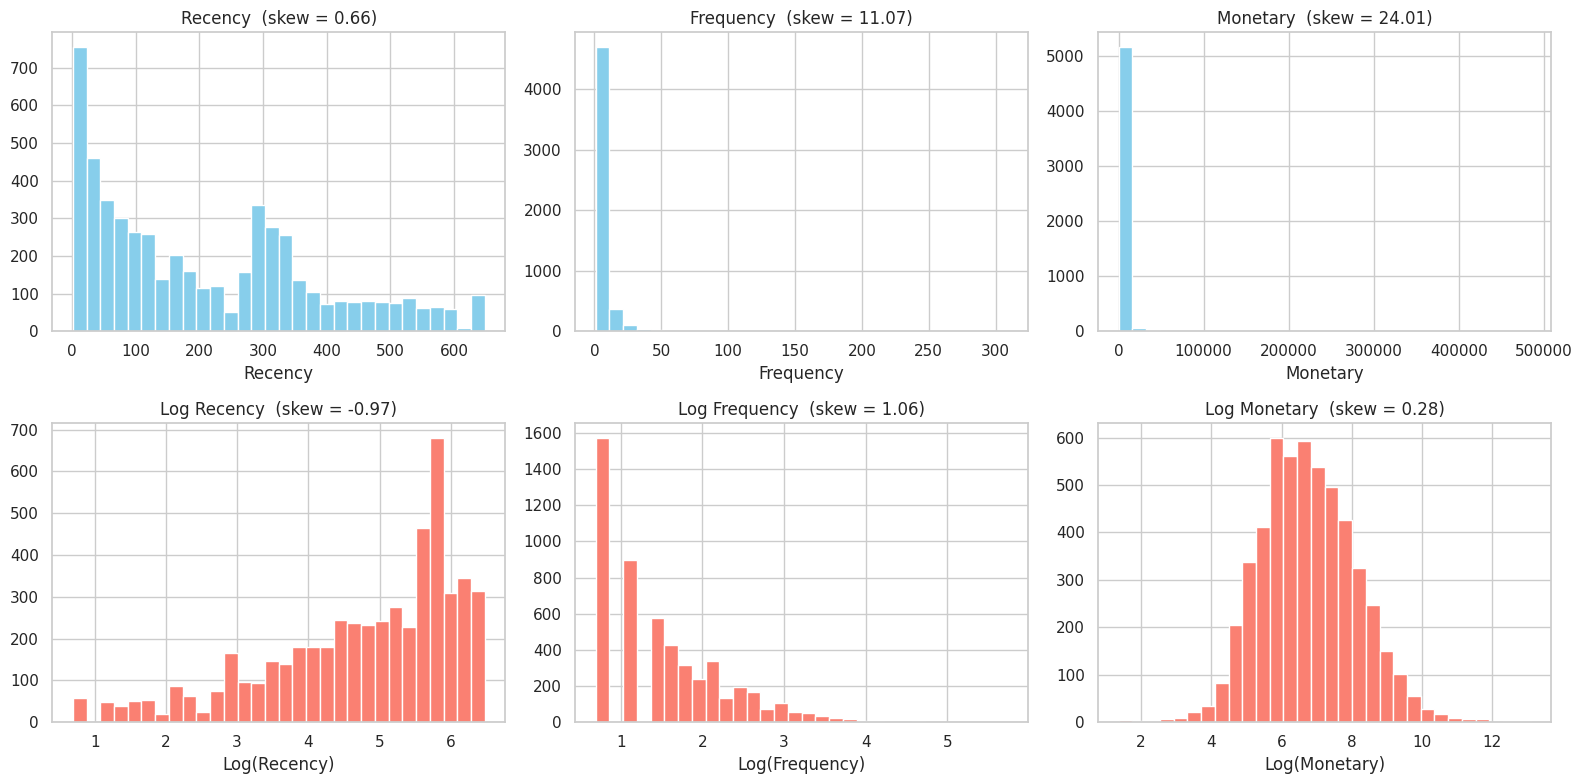

In [62]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for i, col in enumerate(["Recency", "Frequency", "Monetary"]):
    # Raw
    skew_val = rfm[col].skew()
    axes[0, i].hist(rfm[col], bins=30, edgecolor="white", color='skyblue')
    axes[0, i].set_title(f"{col}  (skew = {skew_val:.2f})")
    axes[0, i].set_xlabel(col)

    # Log-transformed (log1p to handle potential zeros)
    log_data = np.log1p(rfm[col])
    log_skew = log_data.skew()
    axes[1, i].hist(log_data, bins=30, edgecolor="white", color="salmon")
    axes[1, i].set_title(f"Log {col}  (skew = {log_skew:.2f})")
    axes[1, i].set_xlabel(f"Log({col})")

plt.tight_layout()
plt.savefig("eda_rfm_distributions.png", dpi=150)
plt.show()

### Summary RFM Distribution

Frequency and Monetary exhibit extreme right skew, violating K-Means' implicit assumption that features are roughly symmetric. A log1p transform reduces these. All subsequent clustering uses log-transformed, standardized features.

In [59]:
# Reset the index so 'Customer ID' becomes a regular column before saving
rfm_final = rfm.reset_index()

# Define the path
save_path = "/content/drive/MyDrive/Colab Notebooks/STA 141C/rfm_cleaned_data.csv"

# Export to CSV
rfm_final.to_csv(save_path, index=False)
print("Data saved successfully to:", save_path)

Data saved successfully to: /content/drive/MyDrive/Colab Notebooks/STA 141C/rfm_cleaned_data.csv
